# Trading Signal Generator for Silver ETF

### Import Libraries and Data

In [1]:
import warnings
warnings.filterwarnings("ignore")

In [2]:
import pandas as pd
import numpy as np

In [3]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use("seaborn-v0_8-darkgrid")

In [4]:
from sklearn.linear_model import LinearRegression

In [5]:
import yfinance as yf

In [6]:
df_slv = yf.download('SLV', '2010-01-01', '2023-11-15', auto_adjust=True)

df_slv = df_slv[['Close']]
df_slv = df_slv.dropna()

df_slv

[*********************100%%**********************]  1 of 1 completed


,Close
Date,
2010-01-04,17.230000
2010-01-05,17.510000
2010-01-06,17.860001
2010-01-07,17.889999
2010-01-08,18.150000
...,...
2023-11-08,20.650000
2023-11-09,20.690001
2023-11-10,20.340000


### Display iShares Silver ETF (SLV) Price Chart

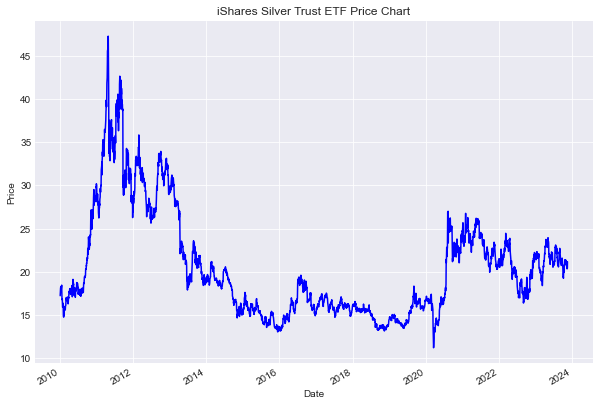

In [7]:
df_slv['Close'].plot(figsize=(10,7), color='blue')
plt.ylabel("Price")
plt.title("iShares Silver Trust ETF Price Chart")
plt.show()

### Define independent and dependent variables

In [8]:
# Fibonacci levels
df_slv['SMA5'] = df_slv['Close'].rolling(window=5).mean()
df_slv['SMA8'] = df_slv['Close'].rolling(window=8).mean()
df_slv['SMA13'] = df_slv['Close'].rolling(window=13).mean()

# Shift row by one to get T+1 price
df_slv['t1_price'] = df_slv['Close'].shift(-1)
df_slv = df_slv.dropna()

# SMAs are independent variables
x = df_slv[['SMA5', 'SMA8', 'SMA13']]

# T+1 price is dependent variable
y = df_slv['t1_price']

### Create Linear Regression model and use it to predict T+1 prices of Silver ETF

In [9]:
t = 0.8
t = int(t * len(df_slv))

x_train = x[:t]
y_train = y[:t]

x_test = x[t:]
y_test = y[t:]

In [10]:
# Create a linear regression model
lr = LinearRegression().fit(x_train, y_train)

# Regression equation
print("y = (m1 * x1) + (m2 * x2) + (m3 * x3)  + c")
print()

print("y: predicted price of silver ETF")
print()
print("x(n): a given simple moving average, where n = no of days")
print("m(n): a given coffeicient, wehere n = coefficient number")

print()

# 1st coefficient (5 SMA)
print("m1: " + str(lr.coef_[0]))

# 2nd coefficient (8 SMA)
print("m2: " + str(lr.coef_[1]))

# 2nd coefficient (8 SMA)
print("m3: " + str(lr.coef_[2]))

print()

# c intercept
print("c: " + str(lr.intercept_))


y = (m1 * x1) + (m2 * x2) + (m3 * x3)  + c

y: predicted price of silver ETF

x(n): a given simple moving average, where n = no of days
m(n): a given coffeicient, wehere n = coefficient number

m1: 1.8076541930711554
m2: -0.8278880109334247
m3: 0.015265693811866016

c: 0.10562352045895196


### Compare predictions against actual prices on time series chart

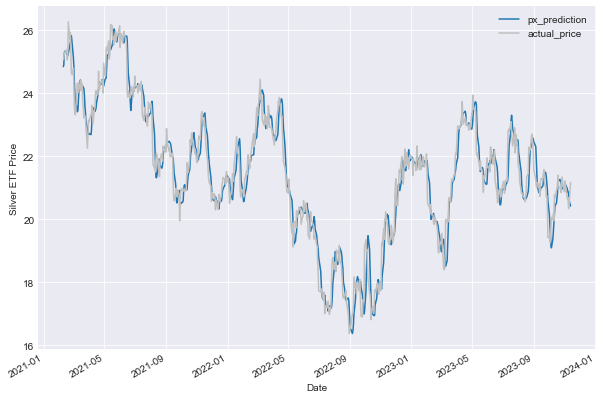

In [11]:
px_prediction = lr.predict(x_test)
px_prediction = pd.DataFrame(px_prediction, index=x_test.index, columns=['price'])
px_prediction.plot(figsize=(10,7))
y_test.plot(color="silver")
plt.legend(['px_prediction','actual_price'])
plt.ylabel("Silver ETF Price")
plt.show()

In [12]:
# R^2 score
r2 = lr.score(x[t:], y[t:]) * 100
r2

94.63092389765477

### Cumulative Return Analysis

In [13]:
silver = pd.DataFrame()

In [14]:
silver['price'] = df_slv[t:]['Close']
silver['predicted_t1'] = px_prediction
silver['actual_t1'] = y_test

# pct calculates changes between T and T+1, shifted back one row to assign calculated pct_move to T
silver['silver_returns'] = silver['price'].pct_change().shift(-1)

In [15]:
silver['signal'] = np.where(silver.predicted_t1.shift(1) < silver.predicted_t1, 1, 0)

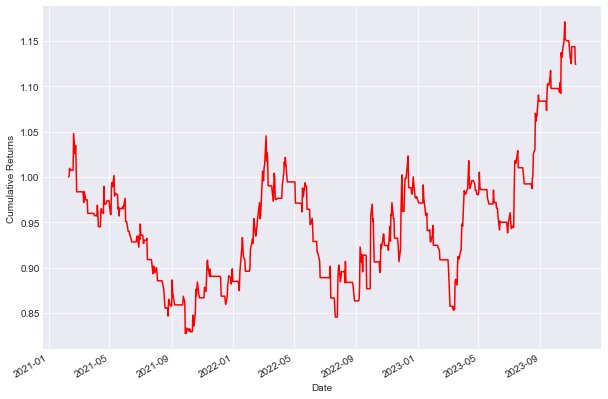

In [16]:
silver['strat_returns'] = silver.signal * silver['silver_returns']
((silver['strat_returns']+1).cumprod()).plot(figsize=(10,7),color='r')
plt.ylabel('Cumulative Returns')
plt.show()

In [17]:
# Sharpe Ratio
sr = silver['strat_returns'].mean()/silver['strat_returns'].std()*(252**0.5)
sr

0.31932163745056746

### Trading Signal in Practice (LONG or NO ACTION)

In [18]:
import datetime as dt
curr_date = dt.datetime.now()

# Retrieve historical silver etf data
slv_data = yf.download('SLV', '2010-01-01', curr_date, auto_adjust=True)

# Calculating moving avergaes
slv_data['SMA5'] = slv_data['Close'].rolling(window=5).mean()
slv_data['SMA8'] = slv_data['Close'].rolling(window=8).mean()
slv_data['SMA13'] = slv_data['Close'].rolling(window=13).mean()

slv_data = slv_data.dropna()

# Forecast using linear regression
slv_data['px_prediction'] = lr.predict(slv_data[['SMA5', 'SMA8', 'SMA13']])
slv_data['signal'] = np.where(slv_data.px_prediction.shift(1) < slv_data.px_prediction, "LONG", "NO ACTION")

# Latest signal
slv_data['px_prediction'] = slv_data['px_prediction'].round(2)
slv_data.tail(1)[['signal','px_prediction']].T

[*********************100%%**********************]  1 of 1 completed


Date,2023-11-16
signal,LONG
px_prediction,21.14
